In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [38]:
data = pd.read_csv('metadata.csv')

data['country'] = data['country'].fillna('USA')
data['language'] = data['language'].fillna('English')
data['content_rating'] = data['content_rating'].fillna('R')

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
variables = ['language','country','content_rating']
for i in variables:
    data[i] = le.fit_transform(data[i])

Genere_avail = []
for i in data['genres']:
    full = i.split('|')
    for j in full:
        if j not in Genere_avail:
            Genere_avail.append(j)
            
data['first_genre'] = data['genres'].apply(lambda x:x.split('|')[0])          
le = LabelEncoder()
data['first_genre'] = le.fit_transform(data['first_genre'])
            
for i in Genere_avail:
    data[i] = data['genres'].apply(lambda x:1 if i in x else 0)

data['num_critic_for_reviews'].fillna(data['num_critic_for_reviews'].mean(), inplace=True)
data['duration'].fillna(data['duration'].mean(), inplace=True)
data['facenumber_in_poster'].fillna(data['facenumber_in_poster'].mean(), inplace=True)

data.director_facebook_likes.fillna(data.cast_total_facebook_likes.apply(lambda x:round(x/6)),inplace = True)
data.actor_1_facebook_likes.fillna(data.cast_total_facebook_likes.apply(lambda x:round(2*x/6)),inplace = True)
data.actor_2_facebook_likes.fillna(data.cast_total_facebook_likes.apply(lambda x:round(2*x/6)),inplace = True)
data.actor_3_facebook_likes.fillna(data.cast_total_facebook_likes.apply(lambda x:round(2*x/6)),inplace = True)

data['ar_string'] = data['aspect_ratio'].apply(lambda x:str(x) if x!=np.nan else x)
data['ar_string'] = data['ar_string'].apply(lambda x:np.nan if x=='nan' else x)
data['ar_string'].fillna('2.35', inplace=True)

#filling na for budget basing on aspect ratio and dropping budget
table = data.pivot_table(values = 'budget',index = ['ar_string'],aggfunc=np.median)

def func1(x):
    if x['budget']>= 0.0:
        return x
    elif(x['ar_string'] == '4.0' or x['ar_string'] == '1.44'):
        return 0.0
    else:
        x['budget'] = table.loc[x['ar_string']].iloc[0]
    return x
data = data.apply(func1, axis=1)
data.drop(['genres','aspect_ratio','gross'],axis=1, inplace=True)

data['duration'] = round(data['duration']/60)

#data['imdb_score'] = round(data['imdb_score'])

data['budget'] = data['budget']/10000000

In [39]:
data.head()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,language,country,content_rating,...,War,Biography,Music,Documentary,Game-Show,Reality-TV,News,Short,Film-Noir,ar_string
0,723.0,3.0,0.0,855.0,1000.0,4834.0,0.0,11.0,62.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.78
1,302.0,3.0,563.0,1000.0,40000.0,48350.0,0.0,11.0,62.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.35
2,602.0,2.0,0.0,161.0,11000.0,11700.0,1.0,11.0,61.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.35
3,813.0,3.0,22000.0,23000.0,27000.0,106759.0,0.0,11.0,62.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.35
4,462.0,2.0,475.0,530.0,640.0,1873.0,1.0,11.0,62.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.35


In [118]:
from sklearn.model_selection import train_test_split
predictor_var = ['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'language', 'country', 'content_rating',
       'budget', 'actor_2_facebook_likes', 'first_genre',
       'Drama', 'Horror', 'Documentary','ar_string']
outcome_var = 'imdb_score'
X_train, X_test, y_train, y_test = train_test_split(data[predictor_var],data[outcome_var],test_size=0.33, random_state=42)

In [120]:
from sklearn import ensemble
model=ensemble.GradientBoostingRegressor(loss='ls',learning_rate=0.03,n_estimators=200,max_depth=6)
model.fit(X_train,y_train)

pred=model.predict(X_test)
error=model.loss_(y_test,pred) ##Loss function== Mean square error
print("MSE:%.3f" % error)

result = 0
for p,r in zip(pred,y_test.values):
    if (p-r <= 1.0 and p-r > 0) or (r-p <= 1.0 and r-p > 0):
        result += 1

accuracy = round(result/len(pred),4)*100
print(accuracy)

MSE:0.744
80.23


Text(0, 0.5, 'Feature Importance Score')

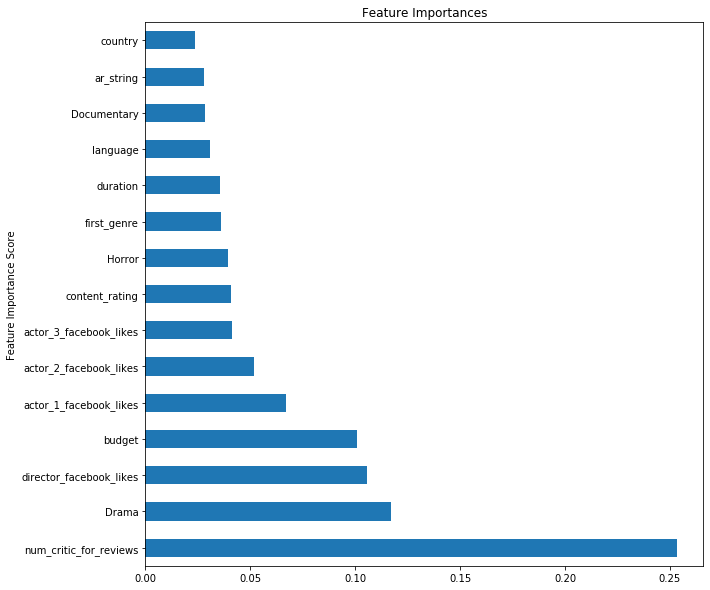

In [105]:
feat_imp = pd.Series(model.feature_importances_, predictor_var).sort_values(ascending=False)
feat_imp.plot(kind='barh', title='Feature Importances',figsize=(10,10))
plt.ylabel('Feature Importance Score')

In [121]:
model.fit(data[predictor_var],data[outcome_var])  #finally fitting on whole data

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.03, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [128]:
import dill as pickle
filename = 'write.pk'
with open(filename, 'wb') as file:
    pickle.dump(model, file)